## Mphasis DeepInsights Face Recognition Algorithm

This is a trainable algorithm which detects and recognizes faces of individuals on which the model is trained.

Mphasis DeepInsights face recognition algorithm detects the faces present in the image data and uses the concepts of transfer learning to extract high quality features from the facial data known as face embeddings. These face embedding are used to train the machine learning model for face identification.

Mphasis DeepInsights Face recognition algorithm is a two-step solution. First it identifies the facial features present in the data and then converts them into high quality features know as face embedding. The solution provides the mechanism to train as well as test on user specific data for face identification.

This sample notebook shows you how to deploy Mphasis DeepInsights Face Recognition Algorithm using Amazon SageMaker.

> **Note**: This is a reference notebook and it cannot run unless you make changes suggested in the notebook.

#### Pre-requisites:
1. **Note**: This notebook contains elements which render correctly in Jupyter interface. Open this notebook from an Amazon SageMaker Notebook Instance or Amazon SageMaker Studio.
1. Ensure that IAM role used has **AmazonSageMakerFullAccess**
1. To deploy this ML model successfully, ensure that:
    1. Either your IAM role has these three permissions and you have authority to make AWS Marketplace subscriptions in the AWS account used: 
        1. **aws-marketplace:ViewSubscriptions**
        1. **aws-marketplace:Unsubscribe**
        1. **aws-marketplace:Subscribe**  
    2. or your AWS account has a subscription to Face Recognition Algorithm. If so, skip step: [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
    3. Make sure to install below mentioned python libraries before running this notebook
    
#### Contents:
1. [Subscribe to the model package](#1.-Subscribe-to-the-model-package)
2. [Usage Instruction](#2.-Usage-Instruction)
3. [Training](#3.-Training) 
4. [Sample Data](#4.-Sample-Data)
5. [Perform batch inference](#5.-Perform-batch-inference)
6. [Create an endpoint and perform real-time inference](#6.-Create-an-endpoint-and-perform-real-time-inference)
7. [Clean-up](#7.-Clean-up)
    

#### Usage instructions
You can run this notebook one cell at a time (By using Shift+Enter for running a cell).

### 1. Subscribe to the model package

To subscribe to the model package:
1. Open the algorithm listing page **Face Recognition Algorithm**
1. On the AWS Marketplace listing, click on the **Continue to subscribe** button.
1. On the **Subscribe to this software** page, review and click on **"Accept Offer"** if you and your organization agrees with EULA, pricing, and support terms. 
1. Once you click on **Continue to configuration button** and then choose a **region**, you will see a **Product Arn** displayed. This is the model package ARN that you need to specify while creating a deployable model using Boto3. Copy the ARN corresponding to your region and specify the same in the following cell.

### 2. Usage Instruction

The deployed solution has these **2 steps**: Training the algorithm and Testing

<li>: The system trains on user provided image dataset.
<li>: The image dataset should contain folders with name of the person and the corresponding folder should contain facial images of only that person.
<li>: The machine learning model is trained in the training step and once the model is generated, it can be used to predict person's identity on test dataset.
<li>: The image dataset folder should be provided as a zip file.
<li>: The testing API takes input of single image and the format of input and output is json.
<li>: In the usage instruction notebook, the detailed steps are mentioned to read an image, convert it to json, predict the output and interpret the output in user friendly manner.

#### Input:
** Following are the mandatory inputs for both the APIs:**
• Supported content type for Training API: ` application/zip`
• Supported content type for Testing API: ` application/json`
• The training image dataset should have atleast 15 images of each person

#### Output:
•  Content types: ` application/json`
•	Output will be a json array of the properties of persons identified. These properties will include the name of the person, confidence and coordinates of the box enclosing faces present in the image.
#### Invoking endpoint
##### AWS CLI Command
If you are using real time inferencing, please create the endpoint first and then use the  following command to invoke it:
``` bash 
aws sagemaker-runtime invoke-endpoint --endpoint-name "endpoint-name" --body fileb://$file_name --content-type application/json --accept application/output.json
```
Substitute the following parameters:
* `"endpoint-name"` - name of the inference endpoint where the model is deployed.
* `file_name` - Input json file name
* `application/json` - type of the given input file.
* `output.json` - filename where the inference results are written to.

In [1]:
import base64 
import uuid
from sagemaker import ModelPackage
import sagemaker as sage
from sagemaker import get_execution_role
from sagemaker import ModelPackage
import boto3
from IPython.display import Image
from PIL import Image
import numpy as np
import pandas as pd
import cv2
from numpy import asarray
import os

In [2]:
role = get_execution_role()

sagemaker_session = sage.Session()

bucket=sagemaker_session.default_bucket()
bucket

'sagemaker-us-east-2-786796469737'

In [3]:
# S3 prefixes
common_prefix = "face_recognition"
training_input_prefix = common_prefix + "/training-input-data"
batch_inference_input_prefix = common_prefix + "/batch-inference-input-data"

In [4]:
sagemaker_session = sage.Session()

In [5]:
TRAINING_WORKDIR = "data/training"

TRAINING_DATA = TRAINING_WORKDIR + "/train.zip"

In [6]:
TRAINING_WORKDIR = "data/training"

# training input location
training_input = sagemaker_session.upload_data(TRAINING_WORKDIR, key_prefix=training_input_prefix)

Training Data Location s3://sagemaker-us-east-2-786796469737/face_recognition/training-input-data


### 3. Training 

In [7]:
import json
import time
from sagemaker.algorithm import AlgorithmEstimator

##### Algorithm ARN

In [22]:
algorithm_arn ='arn:aws:sagemaker:us-east-2:786796469737:algorithm/face-recognition-8'

In [9]:
algo = AlgorithmEstimator(
    algorithm_arn=algorithm_arn,
    role=role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    base_job_name='face-recognition-marketplace')

In [ ]:
print ("Now run the training job using algorithm arn %s in region %s" % (algorithm_arn, sagemaker_session.boto_region_name))
algo.fit({'training': training_input})

### 4. Sample Data

In [11]:
import os
# test data location
TRANSFORM_WORKDIR = "data/transform"
filename = os.path.join(TRANSFORM_WORKDIR, "sample_img.jpg")
image = cv2.imread(filename)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# convert to array
pixels = np.array(image).astype('float32')
pixels_json = {'input_image': pixels.tolist()}
json_object = json.dumps(pixels_json, indent = 4)

api_inputfile = "sample_input.json"
filepath = os.path.join(os.getcwd(), os.path.join(TRANSFORM_WORKDIR, api_inputfile))

with open(filepath, "w") as outfile:
    outfile.write(json_object)

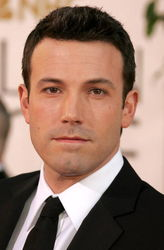

In [12]:
Image.fromarray(image)

### 5. Perform batch inference

In this section, you will perform batch inference using multiple input payloads together. If you are not familiar with batch transform, and want to learn more, see these links:
1. [How it works](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-batch-transform.html)
2. [How to run a batch transform job](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-batch.html)

In [13]:
TRANSFORM_WORKDIR = "data/transform"
transform_input = sagemaker_session.upload_data(TRANSFORM_WORKDIR, key_prefix=batch_inference_input_prefix) + "/sample_input.json"
print("Transform input uploaded to " + transform_input)

Transform input uploaded to s3://sagemaker-us-east-2-786796469737/face_recognition/batch-inference-input-data/sample_input.json


In [ ]:
transformer = algo.transformer(1, 'ml.m4.xlarge')
transformer.transform(transform_input, content_type='application/json')
transformer.wait()

print("Batch Transform output saved to " + transformer.output_path)

#### Inspect the Batch Transform Output in S3

In [15]:
from urllib.parse import urlparse

parsed_url = urlparse(transformer.output_path)
bucket_name = parsed_url.netloc
file_key = '{}/{}.out'.format(parsed_url.path[1:], api_inputfile)

s3_client = sagemaker_session.boto_session.client('s3')

response = s3_client.get_object(Bucket = sagemaker_session.default_bucket(), Key = file_key)

In [16]:
bucketFolder = transformer.output_path.rsplit('/')[3]

In [17]:
import boto3
s3_conn = boto3.client("s3")
bucket_name="sagemaker-us-east-2-786796469737"
with open('output.json', 'wb') as f:
    s3_conn.download_fileobj(bucket_name, bucketFolder+'/' + api_inputfile +'.out', f)
    print("Output file loaded from bucket")

Output file loaded from bucket


In [18]:
with open('output.json') as f:
  output_json = json.load(f)

#### D. Visualize output

In [19]:
for idx in range(len(output_json)):
    person_nm = output_json[idx]["person"]
    confidence = output_json[idx]["confidence"]
    startX = output_json[idx]["x1"]
    startY = output_json[idx]["y1"]
    endX = output_json[idx]["x2"]
    endY = output_json[idx]["y2"]
    color = (100, 255, 0)
    if person_nm == "NOT_IDENTIFIED":
        color = (255, 100, 0)
        label = person_nm
    else:
        label = "{}: {:.2f}%".format(person_nm, confidence)
    cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

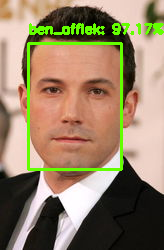

In [20]:
Image.fromarray(image)

### 6. Create an endpoint and perform real-time inference

If you want to understand how real-time inference with Amazon SageMaker works, see [Documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/how-it-works-hosting.html).

In [21]:
model_name='face-recognition'

content_type='application/json'

real_time_inference_instance_type='ml.m5.xlarge'
batch_transform_inference_instance_type='ml.m5.large'

##### Algorithm ARN

In [8]:
algorithm_arn ='arn:aws:sagemaker:us-east-2:786796469737:algorithm/face-recognition-8'

#### A. Create an endpoint

In [24]:
def predict_wrapper(endpoint, session):
    return sage.RealTimePredictor(endpoint, session,content_type)

#create a deployable model from the model package.
model = ModelPackage(role=role,
                    model_package_arn=algorithm_arn,
                    sagemaker_session=sagemaker_session,
                    predictor_cls=predict_wrapper)

#Deploy the model
predictor = algo.deploy(1, 'ml.m4.xlarge',endpoint_name=model_name)

..........
-------------!

Once endpoint has been created, you would be able to perform real-time inference.

#### B. Create input payload

In [ ]:
print(data_frame.head(10))

In [ ]:
import pandas as pd
file_name = './data/input/real-time/input.csv'
data_frame = pd.read_csv(file_name)

#### C. Perform real-time inference

In [25]:
file_name = 'sample_input.json'

In [26]:
output_file_name = 'output.json'

In [28]:
!aws sagemaker-runtime invoke-endpoint \
    --endpoint-name 'face-recognition' \
    --body fileb://$file_name \
    --content-type 'application/json' \
    --region us-east-2 \
    output_file_name


An error occurred (ValidationError) when calling the InvokeEndpoint operation: Endpoint fr-1 of account 786796469737 not found.


In [33]:
!aws sagemaker-runtime invoke-endpoint --endpoint-name $model_name --body fileb://$filepath --content-type 'application/json' --region us-east-2 output_end_point.json

{
    "ContentType": "text/html; charset=utf-8",
    "InvokedProductionVariant": "AllTraffic"
}


In [36]:
with open('output_end_point.json') as f:
  output_2 = json.load(f)

In [37]:
output_2

[{'person': 'ben_afflek',
  'confidence': 97.1668376893,
  'x1': 28,
  'y1': 43,
  'x2': 121,
  'y2': 169}]

#### D. Visualize output

In [38]:
for idx in range(len(output_json)):
    person_nm = output_json[idx]["person"]
    confidence = output_json[idx]["confidence"]
    startX = output_json[idx]["x1"]
    startY = output_json[idx]["y1"]
    endX = output_json[idx]["x2"]
    endY = output_json[idx]["y2"]
    color = (100, 255, 0)
    if person_nm == "NOT_IDENTIFIED":
        color = (255, 100, 0)
        label = person_nm
    else:
        label = "{}: {:.2f}%".format(person_nm, confidence)
    cv2.putText(image, label, (startX, startY - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
    cv2.rectangle(image, (startX, startY), (endX, endY), color, 2)

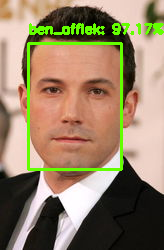

In [39]:
Image.fromarray(image)

### 7. Clean-up

#### A. Delete the model

In [41]:
predictor.delete_endpoint()

#### B. Unsubscribe to the listing (optional)

If you would like to unsubscribe to the model package, follow these steps. Before you cancel the subscription, ensure that you do not have any [deployable model](https://console.aws.amazon.com/sagemaker/home#/models) created from the model package or using the algorithm. Note - You can find this information by looking at the container name associated with the model. 

**Steps to unsubscribe to product from AWS Marketplace**:
1. Navigate to __Machine Learning__ tab on [__Your Software subscriptions page__](https://aws.amazon.com/marketplace/ai/library?productType=ml&ref_=mlmp_gitdemo_indust)
2. Locate the listing that you want to cancel the subscription for, and then choose __Cancel Subscription__  to cancel the subscription.

